<h1>1. Decision Tree </h1>

## 1.1 Loading Data

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re


import pickle
from tqdm import tqdm
import os


from collections import Counter

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas
data = pandas.read_csv('/content/drive/My Drive/Decision Tree/preprocessed_data.csv')

In [90]:
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [91]:
# Splitting Data into features and Class label
Y=data["project_is_approved"]
# dropping the class label 
X=data.drop(columns=["project_is_approved"])

# Number of Data points of each class label
print("Number of points belong to each label")
data["project_is_approved"].value_counts()

Number of points belong to each label


1    92706
0    16542
Name: project_is_approved, dtype: int64

In [0]:
# taken from https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, Y)



In [0]:
X=pd.DataFrame(X_resampled,columns=X.columns)
Y=y_resampled

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [0]:
from sklearn.model_selection import train_test_split
import math
# Stratified Spliting of data into train and test data
xtrain,xtest,ytrain,ytest=train_test_split(X,Y,random_state=52,stratify=Y)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [95]:
#TFIDF conversion of essay column
from sklearn.feature_extraction.text import TfidfVectorizer
tfvectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
tfvectorizer.fit(xtrain["essay"])
x_train_essay_tf=tfvectorizer.transform(xtrain["essay"])
x_test_essay_tf = tfvectorizer.transform(xtest['essay'].values)
print("Shape after TFIDF Vectorization")
print(x_train_essay_tf.shape,ytrain.shape)
print(x_test_essay_tf.shape,ytest.shape)
#print(tfvectorizer.get_feature_names())

Shape after TFIDF Vectorization
(139059, 5000) (139059,)
(46353, 5000) (46353,)


In [0]:
# Using Glove pretrained w2v model
with open('/content/drive/My Drive/Decision Tree/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
#TFIDF W2V conversion of essay column
dictionary = dict(zip(tfvectorizer.get_feature_names(), list(tfvectorizer.idf_)))
tfidf_words = set(tfvectorizer.get_feature_names())


In [0]:
def tfidfw2v(essay):
    tfidf_w2v_vectors = [];
    for sentence in essay: # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)

    print(len(tfidf_w2v_vectors))
    print(len(tfidf_w2v_vectors[0]))
    return(tfidf_w2v_vectors)

In [99]:
x_train_essay_tfw2v=tfidfw2v(xtrain["essay"])


139059
300


In [100]:
x_test_essay_tfw2v=tfidfw2v(xtest["essay"])


46353
300


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [0]:
#Encoding categorical Features
def encodingcategricalfeatures(train,test):
    
    #print(train.shape)
    vectorizer=CountVectorizer()
    vectorizer.fit(train)
    #print(vectorizer.get_feature_names())
    #li.extend(vectorizer.get_feature_names())
    return(vectorizer.transform(train),vectorizer.transform(test))

#calling encodingcategricalfeatures function and storing encoded return features)
x_train_sch_enc,x_test_sch_enc=encodingcategricalfeatures(xtrain['school_state'],xtest["school_state"])
x_train_tchpr_enc,x_test_tchpr_enc=encodingcategricalfeatures(xtrain['teacher_prefix'],xtest["teacher_prefix"])
x_train_prct_enc,x_test_prct_enc=encodingcategricalfeatures(xtrain['project_grade_category'],xtest["project_grade_category"])
x_train_clncat_enc,x_test_clncat_enc=encodingcategricalfeatures(xtrain['clean_categories'],xtest["clean_categories"])
x_train_clnsubcat_enc,x_test_clnsubcat_enc=encodingcategricalfeatures(xtrain['clean_subcategories'],xtest["clean_subcategories"])
#print(x_test_sch_enc[0].toarray())
#print(x_train_sch_enc.shape,ytrain.shape)
#print(x_train_tchpr_enc.shape,ytrain.shape)
#print(x_train_prct_enc.shape,ytrain.shape)
#print(x_train_clncat_enc.shape,ytest.shape)
#print(x_train_clnsubcat_enc.shape,ycv.shape)


In [0]:
# ENcoding Numerical Features
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
def encodingnumericalfeatures(train,test):
    normalizer = Normalizer()
    normalizer.fit(train.values.reshape(1,-1))
    return(normalizer.transform(train.values.reshape(1,-1)),normalizer.transform(test.values.reshape(1,-1)))
    
x_train_tchpst_nor,x_test_tchpst_nor= encodingnumericalfeatures(xtrain["teacher_number_of_previously_posted_projects"],xtest["teacher_number_of_previously_posted_projects"])   
x_train_prc_nor,x_test_prc_nor= encodingnumericalfeatures(xtrain["price"],xtest["price"])   
#print(x_train_prc_nor.max())
#np.argmax(x_train_prc_nor)

In [103]:
from scipy.sparse import hstack

x_tr_tfw2v=hstack((x_train_essay_tfw2v,x_train_sch_enc,x_train_tchpr_enc,x_train_prct_enc,x_train_clncat_enc,x_train_clnsubcat_enc,x_train_tchpst_nor.T,x_train_prc_nor.T)).tocsr()
x_te_tfw2v=hstack((x_test_essay_tfw2v,x_test_sch_enc,x_test_tchpr_enc,x_test_prct_enc,x_test_clncat_enc,x_test_clnsubcat_enc,x_test_tchpst_nor.T,x_test_prc_nor.T)).tocsr()
print("Final Data Matrix after tfidfw2v implentation")
print(x_tr_tfw2v.shape)
print(x_te_tfw2v.shape)

x_tr_tf=hstack((x_train_essay_tf,x_train_sch_enc,x_train_tchpr_enc,x_train_prct_enc,x_train_clncat_enc,x_train_clnsubcat_enc,x_train_tchpst_nor.T,x_train_prc_nor.T)).tocsr()
x_te_tf=hstack((x_test_essay_tf,x_test_sch_enc,x_test_tchpr_enc,x_test_prct_enc,x_test_clncat_enc,x_test_clnsubcat_enc,x_test_tchpst_nor.T,x_test_prc_nor.T)).tocsr()
print(" \nFinal Data Matrix after TFIDF implentation")

print(x_tr_tf.shape)
print(x_te_tf.shape)



Final Data Matrix after tfidfw2v implentation
(139059, 401)
(46353, 401)
 
Final Data Matrix after TFIDF implentation
(139059, 5101)
(46353, 5101)


<h2>1.5 Appling  Decision Tree on different kind of featurization</h2>


In [0]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


#### Applying Grid search and DT on TFIDF featurization




In [19]:
dt = DecisionTreeClassifier(random_state=0)
parameters = {'max_depth':[1,5,10,50], 'min_samples_split':[5, 10, 100, 500]}
clf = GridSearchCV(dt, parameters,scoring="roc_auc",return_train_score=True)
clf.fit(x_tr_tf,ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
    

In [20]:
pd.DataFrame(clf.cv_results_).head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.236274,0.022318,0.031786,0.000441,1,5,"{'max_depth': 1, 'min_samples_split': 5}",0.548972,0.550410,0.549187,0.548936,0.546678,0.548836,0.001207,13,0.549360,0.549036,0.549684,0.549396,0.548163,0.549128,0.000524
1,2.247487,0.026004,0.031650,0.000234,1,10,"{'max_depth': 1, 'min_samples_split': 10}",0.548972,0.550410,0.549187,0.548936,0.546678,0.548836,0.001207,13,0.549360,0.549036,0.549684,0.549396,0.548163,0.549128,0.000524
2,2.216331,0.008986,0.031468,0.000157,1,100,"{'max_depth': 1, 'min_samples_split': 100}",0.548972,0.550410,0.549187,0.548936,0.546678,0.548836,0.001207,13,0.549360,0.549036,0.549684,0.549396,0.548163,0.549128,0.000524
3,2.222540,0.009853,0.032161,0.001043,1,500,"{'max_depth': 1, 'min_samples_split': 500}",0.548972,0.550410,0.549187,0.548936,0.546678,0.548836,0.001207,13,0.549360,0.549036,0.549684,0.549396,0.548163,0.549128,0.000524
4,9.987943,0.090237,0.033230,0.000153,5,5,"{'max_depth': 5, 'min_samples_split': 5}",0.636488,0.644066,0.636655,0.633045,0.635814,0.637214,0.003664,9,0.642676,0.642911,0.642929,0.641274,0.642149,0.642388,0.000624


In [0]:
testscore=list(clf.cv_results_['mean_test_score'])
trainscore=list(clf.cv_results_['mean_train_score'])
x1=list(clf.cv_results_['param_max_depth'])
y1=list(clf.cv_results_['param_min_samples_split'])

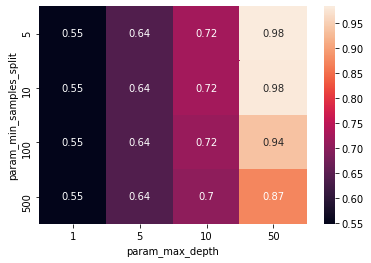

In [22]:
df=pd.DataFrame(list(zip(y1,x1,trainscore)), 
               columns =[ 'param_min_samples_split','param_max_depth','trainscore'])
df=df.pivot('param_min_samples_split',"param_max_depth",'trainscore')
ax = sns.heatmap(df, annot=True)

In [0]:
import plotly.graph_objects as go


In [24]:
trace1 = go.Scatter3d(x=x1,y=y1,z=trainscore, name = 'train')
trace2 = go.Scatter3d(x=x1,y=y1,z=testscore, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
fig.show()

#offline.iplot(fig, filename='3d-scatter-colorscale')

In [25]:
clf.best_params_

{'max_depth': 50, 'min_samples_split': 5}

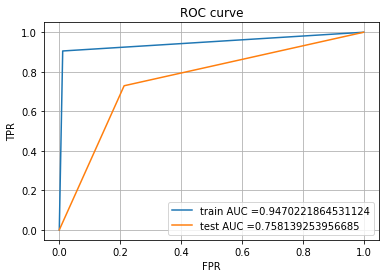

In [26]:
from sklearn.metrics import roc_auc_score
dtf=DecisionTreeClassifier(max_depth=50, min_samples_split=5,random_state=0)
dtf.fit(x_tr_tf,ytrain)
y_test_pred=dtf.predict(x_te_tf)
y_train_pred=dtf.predict(x_tr_tf)
train_fpr, train_tpr, tr_thresholds = roc_curve(ytrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(ytest, y_test_pred)    
#print(tr_thresholds)
#print(test_fpr)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.grid()
plt.show()


In [27]:
auctfidf=(auc(test_fpr, test_tpr))
auctfidf

0.758139253956685

In [28]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(ytrain,y_train_pred))
print("Test confusion matrix")
print(confusion_matrix(ytest,y_test_pred))

Train confusion matrix
[[68751   779]
 [ 6588 62941]]
Test confusion matrix
[[18239  4937]
 [ 6274 16903]]


[[18239  4937]
 [ 6274 16903]]
[[68751   779]
 [ 6588 62941]]


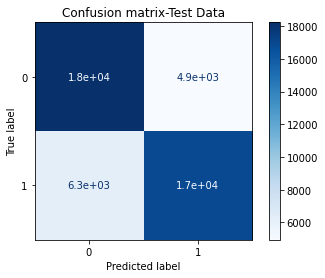

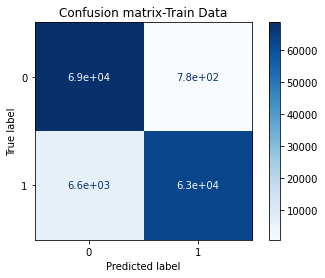

In [29]:
#code taken from sklearn official page
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(dtf, x_te_tf, ytest,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix-Test Data")


print(disp.confusion_matrix)
disp = plot_confusion_matrix(dtf, x_tr_tf, ytrain,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix-Train Data")


print(disp.confusion_matrix)

In [0]:
sen=""
ytest=list(ytest)
y_test_pred=list(y_test_pred)
for i in range(len(ytest)):
    if ytest[i]==0 and y_test_pred[i]==1:
        sen=sen+str(xtest.iloc[i,6])

Word cloud of essay column which predicted as false postive


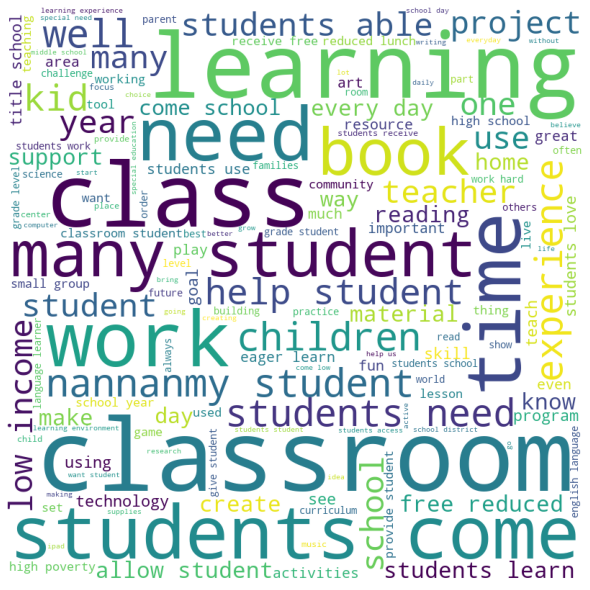

In [31]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(sen) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
print("Word cloud of essay column which predicted as false postive")
plt.show() 

In [0]:
prc=[]
for i in range(len(ytest)):
    if ytest[i]==0 and y_test_pred[i]==1:
        prc.append(xtest.iloc[i,7])

{'boxes': [<matplotlib.lines.Line2D at 0x7fe46085eb00>],
 'caps': [<matplotlib.lines.Line2D at 0x7fe46086ff98>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe460862e48>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe460889d68>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe46085ef98>,
  <matplotlib.lines.Line2D at 0x7fe460862358>]}

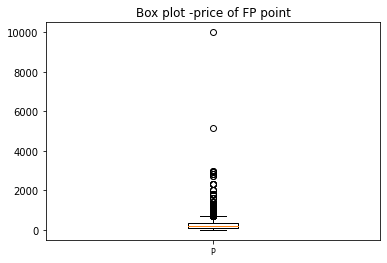

<Figure size 1440x720 with 0 Axes>

In [33]:
fig1, ax1 = plt.subplots()
ax1.set_title('Price of False positive predicted points Plot')
ax1.set_xticklabels("Price",fontsize=8)
ax1.set_title('Box plot -price of FP point')
plt.figure(figsize=(20,10))
ax1.boxplot(prc)

In [0]:
lst_proj=[]
for i in range(len(ytest)):
    if ytest[i]==0 and y_test_pred[i]==1:
        lst_proj.append(xtest.iloc[i,3])

[Text(0.5, 0, '`teacher_number_of_previously_posted_projects` of these `false positive data points`')]

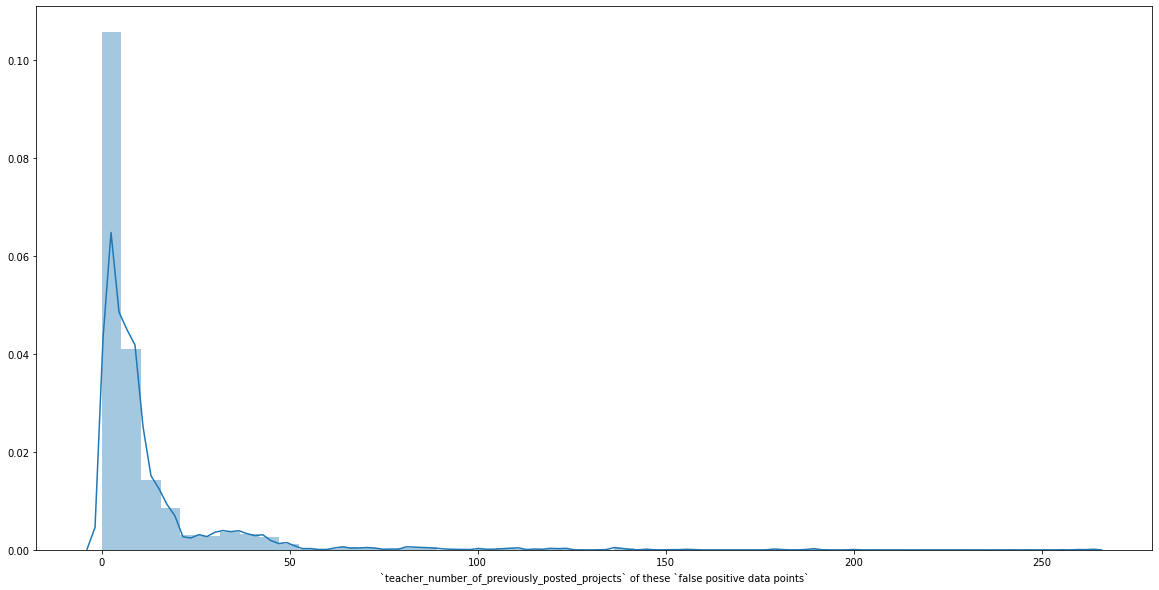

In [35]:


plt.figure(figsize=(20,10))
ax =sns.distplot(lst_proj);
ax.set(xlabel="`teacher_number_of_previously_posted_projects` of these `false positive data points`")

#### Applying Grid search and DT on TFIDFW2V featurization


In [37]:
dt = DecisionTreeClassifier(random_state=0)
parameters = {'max_depth':[1,5,10,50], 'min_samples_split':[5, 10, 100, 500]}
clf = GridSearchCV(dt, parameters,scoring="roc_auc",return_train_score=True)
clf.fit(x_tr_tfw2v,ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
    

In [38]:
testscore=clf.cv_results_['mean_test_score']
trainscore=clf.cv_results_['mean_train_score']
x1=clf.cv_results_['param_max_depth']
y1=clf.cv_results_['param_min_samples_split']
trace1 = go.Scatter3d(x=x1,y=y1,z=trainscore, name = 'train')
trace2 = go.Scatter3d(x=x1,y=y1,z=testscore, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
fig.show()

#offline.iplot(fig, filename='3d-scatter-colorscale')

In [0]:
testscore=list(clf.cv_results_['mean_test_score'])
trainscore=list(clf.cv_results_['mean_train_score'])
x1=list(clf.cv_results_['param_max_depth'])
y1=list(clf.cv_results_['param_min_samples_split'])

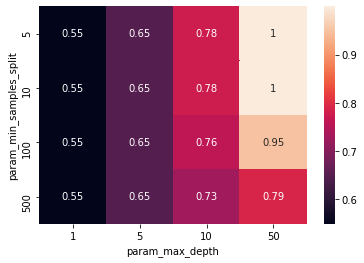

In [43]:
df=pd.DataFrame(list(zip(y1,x1,trainscore)), 
               columns =[ 'param_min_samples_split','param_max_depth','trainscore'])
df=df.pivot('param_min_samples_split',"param_max_depth",'trainscore')
ax = sns.heatmap(df, annot=True)

In [39]:
clf.best_params_

{'max_depth': 50, 'min_samples_split': 10}

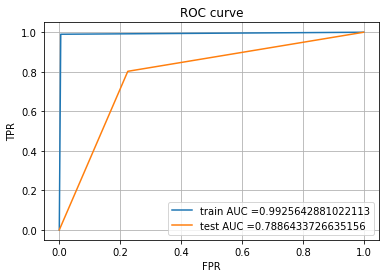

In [36]:
from sklearn.metrics import roc_auc_score
dtf=DecisionTreeClassifier(max_depth=50, min_samples_split=10,random_state=0)
dtf.fit(x_tr_tfw2v,ytrain)
y_test_pred=dtf.predict(x_te_tfw2v)
y_train_pred=dtf.predict(x_tr_tfw2v)
train_fpr, train_tpr, tr_thresholds = roc_curve(ytrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(ytest, y_test_pred)    
#print(tr_thresholds)
#print(test_fpr)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.grid()
plt.show()


In [44]:
auctfidfw2v=(auc(test_fpr, test_tpr))
auctfidfw2v


0.7886433726635156

In [45]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(ytrain,y_train_pred))
print("Test confusion matrix")
print(confusion_matrix(ytest,y_test_pred))


Train confusion matrix
[[69198   332]
 [  702 68827]]
Test confusion matrix
[[17959  5217]
 [ 4580 18597]]


[[17959  5217]
 [ 4580 18597]]
[[69198   332]
 [  702 68827]]


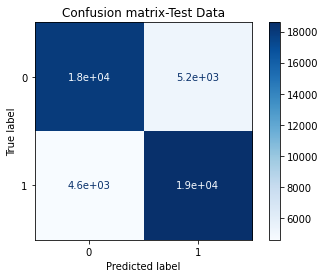

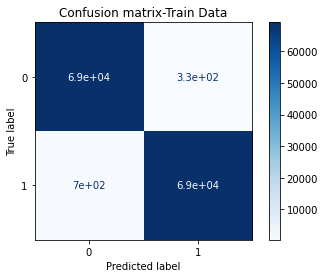

In [46]:

disp = plot_confusion_matrix(dtf, x_te_tfw2v, ytest,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix-Test Data")


print(disp.confusion_matrix)
disp = plot_confusion_matrix(dtf, x_tr_tfw2v, ytrain,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix-Train Data")


print(disp.confusion_matrix)

In [0]:
ytest=list(ytest)
y_pred_test=list(y_test_pred)
for i in range(len(ytest)):
    if ytest[i]==0 and y_pred_test[i]==1:
        sen=sen+str(xtest.iloc[i,6])

Word cloud of essay column which predicted as false postive


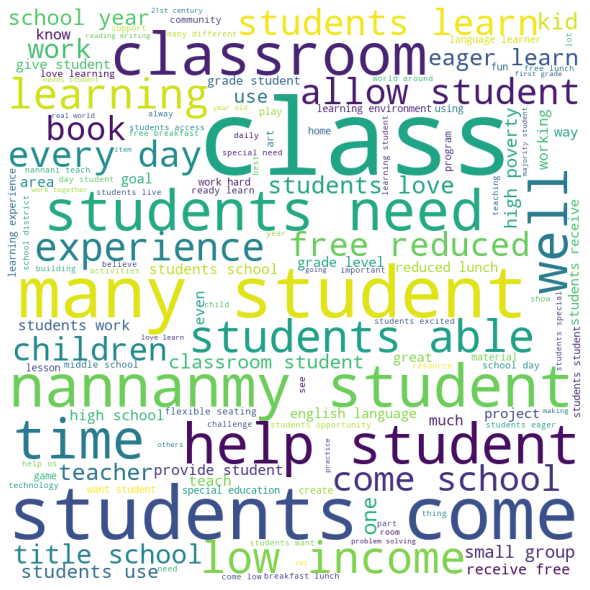

In [48]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(sen) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
print("Word cloud of essay column which predicted as false postive")
plt.show() 

In [0]:
prc=[]
for i in range(len(ytest)):
    if ytest[i]==0 and y_pred_test[i]==1:
        prc.append(xtest.iloc[i,7])


{'boxes': [<matplotlib.lines.Line2D at 0x7fe42c9a6518>],
 'caps': [<matplotlib.lines.Line2D at 0x7fe42c9c9630>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe42c9c9b38>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe42c9c9da0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe42c9a6a20>,
  <matplotlib.lines.Line2D at 0x7fe42c9a6a90>]}

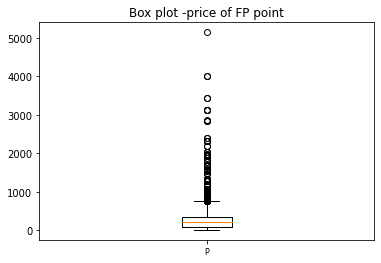

<Figure size 1440x720 with 0 Axes>

In [50]:
fig1, ax1 = plt.subplots()
ax1.set_title('Price of False positive predicted points Plot')
ax1.set_xticklabels("Price",fontsize=8)
ax1.set_title('Box plot -price of FP point')
plt.figure(figsize=(20,10))
ax1.boxplot(prc)

In [0]:
lst_proj=[]
for i in range(len(ytest)):
    if ytest[i]==0 and y_pred_test[i]==1:
        lst_proj.append(xtest.iloc[i,3])

[Text(0.5, 0, '`teacher_number_of_previously_posted_projects` of these `false positive data points`')]

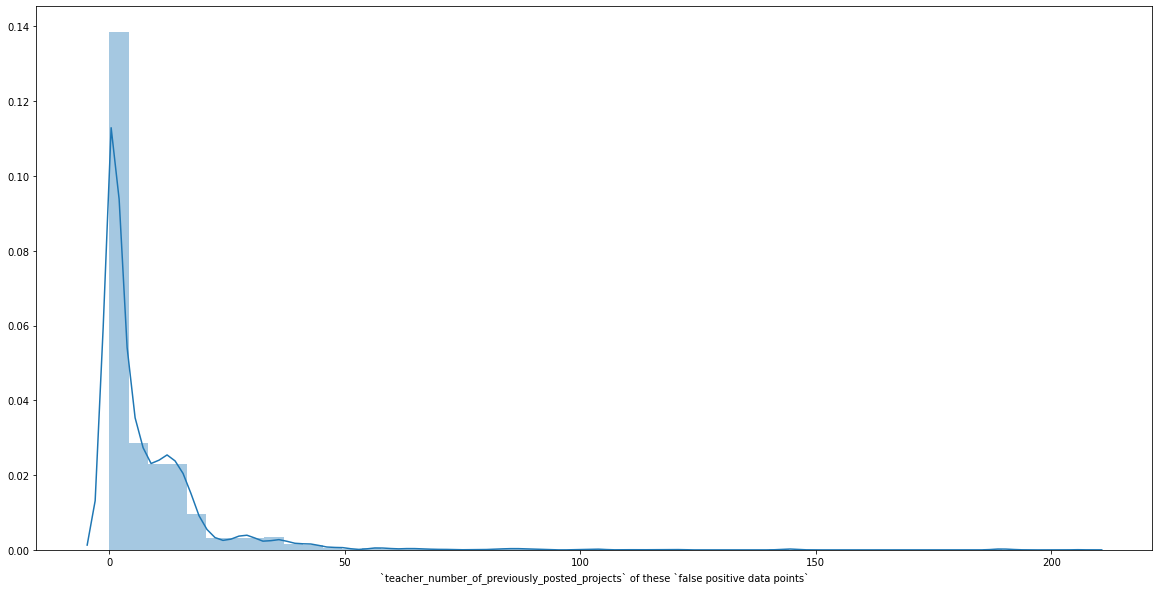

In [52]:


plt.figure(figsize=(20,10))
ax =sns.distplot(lst_proj);
ax.set(xlabel="`teacher_number_of_previously_posted_projects` of these `false positive data points`")

# Feature Extraction 

#### Removing features which has zero feature importance and training DT model.

In [104]:
from sklearn.metrics import roc_auc_score
dtf=DecisionTreeClassifier(max_depth=50, min_samples_split=5,random_state=0)
dtf.fit(x_tr_tf,ytrain)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [105]:
a=list(dtf.feature_importances_)
b=[]
for i in range(len(a)):
    if a[i]!=0:  
      b.append(i)
print(b)
len(b)

[0, 1, 2, 6, 9, 13, 19, 20, 23, 24, 25, 29, 31, 32, 35, 36, 37, 41, 42, 43, 44, 45, 49, 51, 52, 54, 55, 56, 58, 59, 62, 64, 65, 66, 67, 70, 76, 79, 82, 83, 86, 90, 93, 96, 99, 101, 102, 105, 106, 110, 112, 113, 116, 119, 120, 122, 125, 126, 130, 132, 135, 137, 141, 143, 146, 147, 149, 151, 157, 158, 161, 162, 163, 164, 165, 166, 167, 170, 173, 174, 176, 177, 180, 181, 185, 187, 188, 189, 196, 198, 199, 200, 203, 206, 210, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 225, 226, 230, 231, 233, 236, 238, 239, 240, 241, 243, 244, 250, 255, 257, 259, 261, 263, 265, 268, 269, 270, 272, 276, 278, 279, 282, 288, 290, 292, 293, 294, 297, 298, 299, 300, 303, 305, 306, 308, 309, 310, 311, 313, 315, 317, 319, 320, 321, 325, 327, 328, 330, 331, 334, 335, 336, 339, 343, 344, 347, 348, 352, 357, 358, 360, 361, 364, 366, 371, 373, 374, 376, 381, 385, 386, 387, 388, 389, 390, 391, 392, 395, 396, 398, 399, 400, 401, 402, 405, 406, 407, 408, 413, 415, 416, 419, 420, 421, 422, 424, 425, 427,

2291

In [0]:
  X_tr_new=x_tr_tf[:,b]
  X_te_new=x_te_tf[:,b]

In [107]:
print(X_tr_new.shape)

(139059, 2291)


In [108]:
print(X_te_new.shape)

(46353, 2291)


In [109]:
dt = DecisionTreeClassifier(random_state=0)
parameters = {'max_depth':[1,5,10,50], 'min_samples_split':[5, 10, 100, 500]}
clf = GridSearchCV(dt, parameters,scoring="roc_auc",return_train_score=True)
clf.fit(X_tr_new,ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
    

In [110]:
testscore=clf.cv_results_['mean_test_score']
trainscore=clf.cv_results_['mean_train_score']
x1=clf.cv_results_['param_max_depth']
y1=clf.cv_results_['param_min_samples_split']
trace1 = go.Scatter3d(x=x1,y=y1,z=trainscore, name = 'train')
trace2 = go.Scatter3d(x=x1,y=y1,z=testscore, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='param_max_depth'),
        yaxis = dict(title='param_min_samples_split'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
fig.show()


In [0]:
testscore=list(clf.cv_results_['mean_test_score'])
trainscore=list(clf.cv_results_['mean_train_score'])
x1=list(clf.cv_results_['param_max_depth'])
y1=list(clf.cv_results_['param_min_samples_split'])

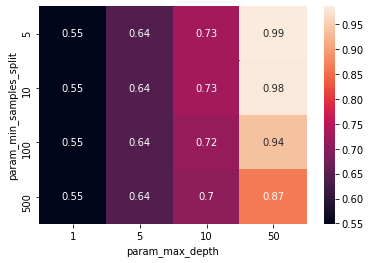

In [113]:
df=pd.DataFrame(list(zip(y1,x1,trainscore)), 
               columns =[ 'param_min_samples_split','param_max_depth','trainscore'])
df=df.pivot('param_min_samples_split',"param_max_depth",'trainscore')
ax = sns.heatmap(df, annot=True)

In [111]:
clf.best_params_

{'max_depth': 50, 'min_samples_split': 5}

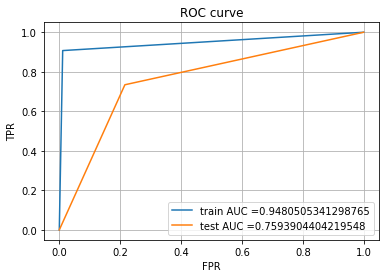

In [114]:
from sklearn.metrics import roc_auc_score
dtf=DecisionTreeClassifier(max_depth=50, min_samples_split=5,random_state=0)
dtf.fit(X_tr_new,ytrain)
y_test_pred=dtf.predict(X_te_new)
y_train_pred=dtf.predict(X_tr_new)
train_fpr, train_tpr, tr_thresholds = roc_curve(ytrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(ytest, y_test_pred)    
#print(tr_thresholds)
#print(test_fpr)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.grid()
plt.show()

In [115]:
auctfidffea=(auc(test_fpr, test_tpr))
auctfidffea

0.7593904404219548

In [116]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(ytrain,y_train_pred))
print("Test confusion matrix")
print(confusion_matrix(ytest,y_test_pred))

Train confusion matrix
[[68753   777]
 [ 6447 63082]]
Test confusion matrix
[[18181  4995]
 [ 6158 17019]]


[[18181  4995]
 [ 6158 17019]]
[[68753   777]
 [ 6447 63082]]


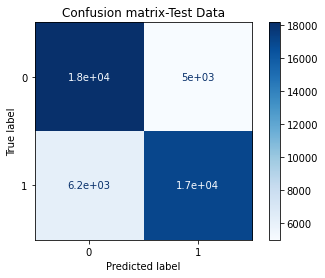

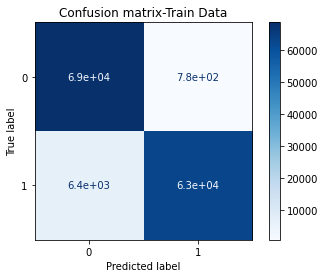

In [117]:
disp = plot_confusion_matrix(dtf, X_te_new, ytest,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix-Test Data")


print(disp.confusion_matrix)
disp = plot_confusion_matrix(dtf, X_tr_new, ytrain,cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix-Train Data")


print(disp.confusion_matrix)

In [0]:
ytest=list(ytest)
y_pred_test=list(y_test_pred)
for i in range(len(ytest)):
    if ytest[i]==0 and y_pred_test[i]==1:
        sen=sen+str(xtest.iloc[i,6])

Word cloud of essay column which predicted as false postive


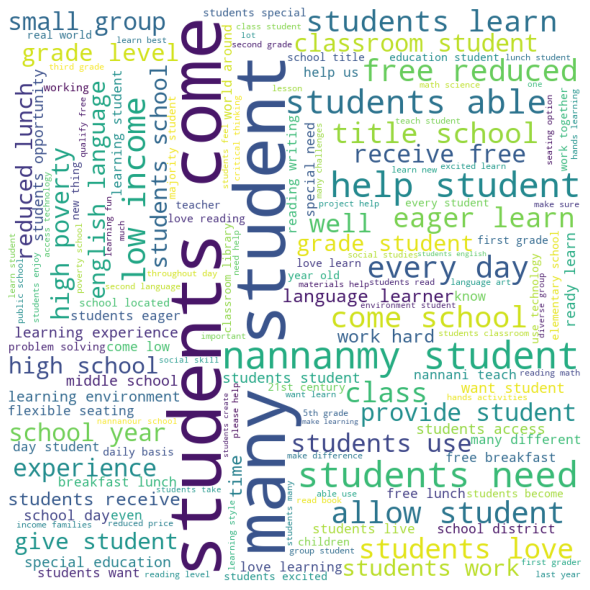

In [119]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(sen) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
print("Word cloud of essay column which predicted as false postive")
plt.show() 

In [0]:
prc=[]
for i in range(len(ytest)):
    if ytest[i]==0 and y_pred_test[i]==1:
        prc.append(xtest.iloc[i,7])


{'boxes': [<matplotlib.lines.Line2D at 0x7fe48016d208>],
 'caps': [<matplotlib.lines.Line2D at 0x7fe48016d780>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe42181fe10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe42181f828>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe48016d6a0>,
  <matplotlib.lines.Line2D at 0x7fe48016dba8>]}

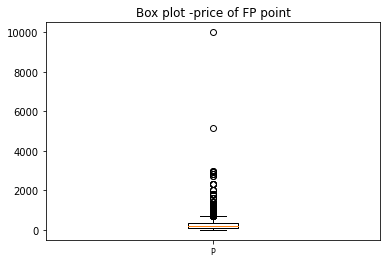

<Figure size 1440x720 with 0 Axes>

In [121]:
fig1, ax1 = plt.subplots()
ax1.set_title('Price of False positive predicted points Plot')
ax1.set_xticklabels("Price",fontsize=8)
ax1.set_title('Box plot -price of FP point')
plt.figure(figsize=(20,10))
ax1.boxplot(prc)

In [0]:
lst_proj=[]
for i in range(len(ytest)):
    if ytest[i]==0 and y_pred_test[i]==1:
        lst_proj.append(xtest.iloc[i,3])

[Text(0.5, 0, '`teacher_number_of_previously_posted_projects` of these `false positive data points`')]

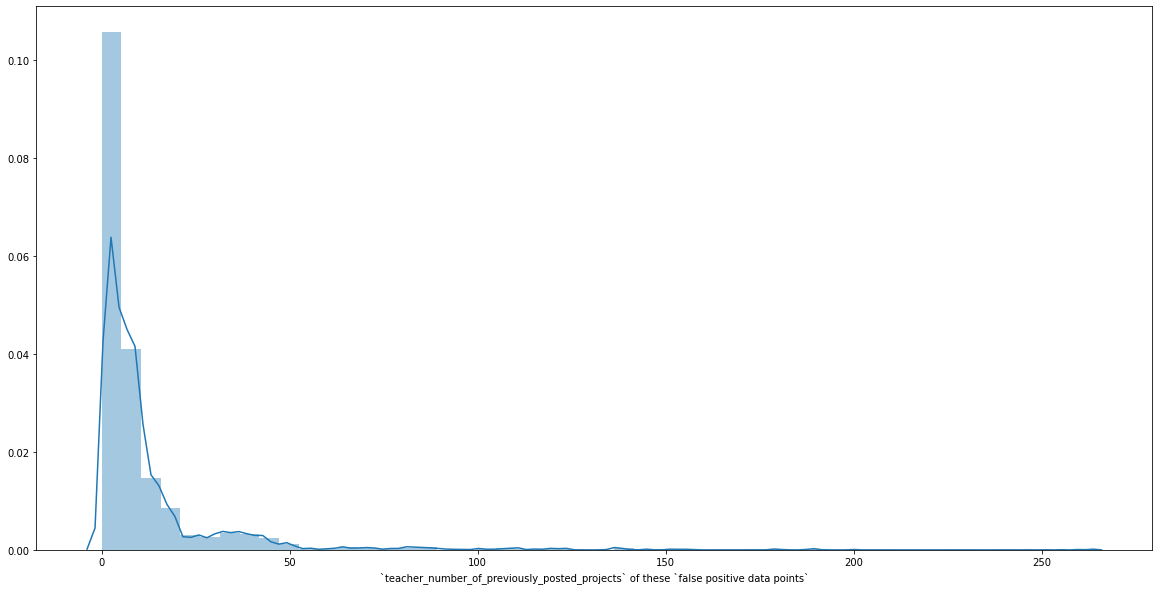

In [123]:


plt.figure(figsize=(20,10))
ax =sns.distplot(lst_proj);
ax.set(xlabel="`teacher_number_of_previously_posted_projects` of these `false positive data points`")

### Adding Sentimentintensityanalyzer and training models

In [1]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid=SentimentIntensityAnalyzer


In [125]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [0]:
negtr=[]
neutr=[]
postr=[]
compoundtr=[]
negte=[]
neute=[]
poste=[]
compoundte=[]

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sentences=[ "We present an intensity neighborhood-based system for segmenting arbitrary biomedical image datasets using supervised learning.Because neighborhood methods are often associated with highdimensional feature vectors"]
sid = SIA()
for sentence in xtrain['essay']:
    #print(sentence)
    ss = sid.polarity_scores(sentence) 
    negtr.append(ss['neg'])
    neutr.append(ss['neu'])
    postr.append(ss['pos'])
    compoundtr.append(ss['compound'])
for sentence in xtest['essay']:
    ss = sid.polarity_scores(sentence) 
    negte.append(ss['neg'])
    neute.append(ss['neu'])
    poste.append(ss['pos'])
    compoundte.append(ss['compound'])

In [127]:
print(len(negtr))
print(len(xtrain))
print(len(negte))
print(len(xtest))


139059
139059
46353
46353


In [128]:
print(X_tr_new.shape)
X_te_new.shape

(139059, 2291)


(46353, 2291)

In [129]:
# Concatinating sentiment analyzer data to train data

from scipy.sparse import coo_matrix,hstack
pos=coo_matrix(np.array(postr))
neu=coo_matrix(np.array(neutr))
neg=coo_matrix(np.array(negtr))
compound=coo_matrix(np.array(compoundtr))
print(pos.shape)
#compound=np.array(compoundtr)
pos=pos.reshape(-1,1)
neu=neu.reshape(-1,1)
neg=neg.reshape(-1,1)
print(pos.shape)
compound=compound.reshape(-1,1)
X_tr_new=hstack((X_tr_new, pos,neu,neg,compound))
X_tr_new.shape


(1, 139059)
(139059, 1)


(139059, 2295)

In [130]:
# Concatinating sentiment analyzer data to test data
from scipy.sparse import coo_matrix,hstack
poste=coo_matrix(np.array(poste))
neute=coo_matrix(np.array(neute))
negte=coo_matrix(np.array(negte))
compoundte=coo_matrix(np.array(compoundte))
print(poste.shape)
#compound=np.array(compoundtr)
poste=poste.reshape(-1,1)
neute=neute.reshape(-1,1)
negte=negte.reshape(-1,1)
print(poste.shape)
compoundte=compoundte.reshape(-1,1)
X_te_new=hstack((X_te_new, poste,neute,negte,compoundte))
X_te_new.shape

(1, 46353)
(46353, 1)


(46353, 2295)

In [131]:
dt = DecisionTreeClassifier(random_state=0)
parameters = {'max_depth':[1,5,10,50], 'min_samples_split':[5, 10, 100, 500]}
clf = GridSearchCV(dt, parameters,scoring="roc_auc",return_train_score=True)
clf.fit(X_tr_new,ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
    

In [132]:
clf.best_params_

{'max_depth': 50, 'min_samples_split': 5}

In [0]:
testscore=list(clf.cv_results_['mean_test_score'])
trainscore=list(clf.cv_results_['mean_train_score'])
x1=list(clf.cv_results_['param_max_depth'])
y1=list(clf.cv_results_['param_min_samples_split'])

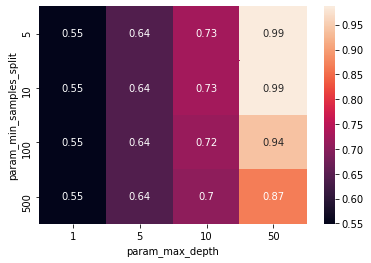

In [134]:
df=pd.DataFrame(list(zip(y1,x1,trainscore)), 
               columns =[ 'param_min_samples_split','param_max_depth','trainscore'])
df=df.pivot('param_min_samples_split',"param_max_depth",'trainscore')
ax = sns.heatmap(df, annot=True)

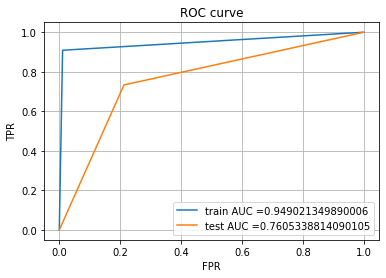

In [135]:
from sklearn.metrics import roc_auc_score
dtf=DecisionTreeClassifier(max_depth=50, min_samples_split=5,random_state=0)
dtf.fit(X_tr_new,ytrain)
y_test_pred=dtf.predict(X_te_new)
y_train_pred=dtf.predict(X_tr_new)
train_fpr, train_tpr, tr_thresholds = roc_curve(ytrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(ytest, y_test_pred)    
#print(tr_thresholds)
#print(test_fpr)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.grid()
plt.show()

In [136]:
auctfidNLTK=(auc(test_fpr, test_tpr))
auctfidNLTK

0.7605338814090105

In [137]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(ytrain,y_train_pred))
print("Test confusion matrix")
print(confusion_matrix(ytest,y_test_pred))

Train confusion matrix
[[68774   756]
 [ 6333 63196]]
Test confusion matrix
[[18252  4924]
 [ 6176 17001]]


In [138]:
from tabulate import tabulate

table = [["tfidf","DT",auctfidf],["tfidfw2v","DT", auctfidfw2v],["tfidf+Feature Extraction","DT",auctfidffea],["tfidf+Feature Extractio+SENTIMENT ANALYZER","DT",auctfidNLTK]]
headers = ["VECTORIZER", "MODEL","AUC SCORE"]
print(tabulate(table, headers, tablefmt="grid"))

+--------------------------------------------+---------+-------------+
| VECTORIZER                                 | MODEL   |   AUC SCORE |
+============================================+=========+=============+
| tfidf                                      | DT      |    0.758139 |
+--------------------------------------------+---------+-------------+
| tfidfw2v                                   | DT      |    0.788643 |
+--------------------------------------------+---------+-------------+
| tfidf+Feature Extraction                   | DT      |    0.75939  |
+--------------------------------------------+---------+-------------+
| tfidf+Feature Extractio+SENTIMENT ANALYZER | DT      |    0.760534 |
+--------------------------------------------+---------+-------------+


In [0]:
I

#### Applying Grid search and DT on TFIDFW2V featurization

In [0]:
dt2 = DecisionTreeClassifier(random_state=0)
parameters2 = {'max_depth':[1,5,10,50], 'min_samples_split':[5, 10, 100, 500]}
clf2 = GridSearchCV(dt, parameters2,scoring="roc_auc",return_train_score=True)
clf2.fit(x_tr_tfw2v,ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
    

In [0]:
testscore=clf2.cv_results_['mean_test_score']
trainscore=clf2.cv_results_['mean_train_score']
x1=clf2.cv_results_['param_max_depth']
y1=clf2.cv_results_['param_min_samples_split']

In [0]:
trace1 = go.Scatter3d(x=x1,y=y1,z=trainscore, name = 'train')
trace2 = go.Scatter3d(x=x1,y=y1,z=testscore, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
fig.show()

In [0]:
param

array([0.55151974, 0.55151974, 0.55151974, 0.55151974, 0.6280787 ,
       0.62803342, 0.62802289, 0.6279966 , 0.64547836, 0.6452213 ,
       0.64964472, 0.65149479, 0.54544487, 0.55288905, 0.57846323,
       0.61635029])